# Breweries and Wineries in Finger Lakes Region of New York State
#### Authored by Lauren Oldham, September 12, 2019, New Maps Plus MAP-674

## Table of Contents
1. [Introduction](#introduction)
    1. [About the Data](#about)
        1. [New York Breweries and Wineries](#ny-beer-wine)
        2. [Shapefiles](#shapefiles)
2. [Import Data](#import-data)
3. [Prepare for GeoPandas Geoprocessing](#geopandas-prep)
    1. [Drop Null Latitude and Longitudes](#drop-null)
    2. [Convert DataFrame to GeoDataFrame](#convert-gdf)
    3. [Subset New York States and Counties](#subset)
    4. [Check Data](#check-1)
4. [Geoprocess with GeoPandas](#geoprocessing)
    1. [Clip Dataset](#clip)
        1. [Unary Union](#union)
    2. [Reproject Data](#reproject)
    3. [Check Data](#check-2)
    4. [Additional Subsetting and Splitting of Data](#additional-subset)
    5. [Apply Buffer to Wineries Dataset](#buffer)
    6. [Intersect Half-Mile Buffer Against Dataset](#intersect-1)
        1. [Breweries](#breweries)
        2. [Check Data](#check-3)
        3. [Wineries](#wineries)
5. [Final Plot and Analysis](#final-plot)
6. [Export Results](#export)
    1. [Export Dataset](#export-dataset)
    2. [Export Counties to JSON](#export-counties)

## Introduction<a name="introduction"></a>
If you're talking about the Finger Lakes, chances are that you're also talking about wine. Home to one of the most famous wine-producing regions in the world, upstate New York is a popular tourist destination, and a favorite activity is imbibing. From fall foliage excursions to bachelorette parties, many tour groups hop from establishment to establishment to taste all of what the region has to offer. Many wineries are closely clustered, inviting other restarants, distilleries, and breweries to build nearby. So why limit yourself to wine when so many establishments are within walking distance? Our goal today is to find the wineries and breweries that are within a half mile of one another to allow tourists and residents to walk from establishment to establishment without relying on transportation.

### About the Data<a name="about"></a>
#### New York Breweries and Wineries<a name="ny-beer-wine"></a>
Wineries, Breweries, and Distilleries data provided by https://data.ny.gov/.

Based on Liquor Authority Quarterly List of Active Licenses

Liquor Authority quarterly list of all active licensees in NYS filtered by Winery and Brewery specific License Types.

https://data.ny.gov/Economic-Development/Wineries-Breweries-and-Distilleries-Map/c2hv-vmqn

#### Shapefiles<a name="shapefiles"></a>
United States state and county shapefiles provided by GADM.

https://gadm.org/download_country_v3.html

## Import Data<a name="import-data"></a>

In [1]:
# import required data packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# set pyplot figure size for entire project
plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
# import usa state and county shapefiles
# data/shapefiles.zip must be unzipped to access these files
us_states = gpd.read_file('./data/shapefiles/gadm36_USA_1.shp')
us_counties = gpd.read_file('./data/shapefiles/gadm36_USA_2.shp')

In [3]:
# import cleaned New York state breweries and wineries dataset
ny_beer_wine_df = pd.read_csv('./data/ny_beer_wine.csv')

## Prepare for GeoPandas Geoprocessing<a name="geopandas-prep"></a>

While the New York breweries, wineries, and distilleries dataset was cleaned prior to this project, 
datasets often present problems as you are actively working with them. We need to further manipulate both our dataframe and shapefiles before plotting and geoprocessing our data.

### Drop Null Latitude and Longitudes<a name="drop-null"></a>
In this case, missing latitude and longitude values created null GeoDataFrame geometries, preventing proper geoprocessing methods. Dropping rows with NA coordinates fixes this issue.

In [4]:
# drop any rows with NA/null values from dataframe
ny_beer_wine_df = ny_beer_wine_df.dropna()

### Convert DataFrame to GeoDataFrame<a name="convert-gdf"></a>

As great of a data manipulation package as Pandas is, a GeoDataFrame is required to work with GeoPandas! Therefore, we must convert our DataFrame to a GeoDataFrame before plotting and geoprocessing our dataset.

In [5]:
# create Point geometry from dataframe's longitude and latitude columns
geom = [Point(xy) for xy in zip(ny_beer_wine_df.lng, ny_beer_wine_df.lat)]

# create new GeoDataFrame to access and apply geoprocessing methods
ny_beer_wine = gpd.GeoDataFrame(
    ny_beer_wine_df,  # original dataframe
    crs = {'init': 'epsg:4326'},  # WGS84 web mercator CRS
    geometry = geom
)

### Subset New York States and Finger Lakes Counties<a name="subset"></a>

While GADM provides excellent shapefiles of entire countries, we are only interested in New York state and counties for this map. Using basic subsetting, we are able to filter both shapefiles for the desired state. We also want to look at the Finger Lakes Region of upstate New York specifically, so we will subset for those counties as well.

In [6]:
# subset state and county shapefiles for New York only
ny_state = us_states[us_states['NAME_1'] == 'New York']
ny_counties = us_counties[us_counties['NAME_1'] == 'New York']

In [7]:
# create subset of just finger lakes counties
finger_lakes_counties = ny_counties.query(
    "NAME_2 == ['Cayuga', 'Chemung', 'Cortland', 'Livingston', 'Monroe', 'Onondoga', 'Ontario', 'Schuyler', 'Seneca', 'Steuben', 'Tioga', 'Tompkins', 'Wayne', 'Yates']")

### Check Data<a name="check-1"></a>

Let's take a quick look at our data to make sure it's what we expect!

In [8]:
# quick view of dataset - everything looks how we expect!
finger_lakes_counties.head(14)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
1835,USA,United States,USA.33_1,New York,None,USA.33.6_1,Cayuga,None,None,County,County,None,US.NY.CY,POLYGON ((-76.66667938232422 42.62417221069342...
1837,USA,United States,USA.33_1,New York,None,USA.33.8_1,Chemung,None,None,County,County,None,US.NY.CM,POLYGON ((-76.96510314941406 42.00231170654303...
1841,USA,United States,USA.33_1,New York,None,USA.33.12_1,Cortland,None,None,County,County,None,US.NY.CD,POLYGON ((-76.12576293945312 42.41067123413086...
1856,USA,United States,USA.33_1,New York,None,USA.33.27_1,Livingston,None,None,County,County,None,US.NY.LI,"POLYGON ((-78.0389404296875 42.52143859863287,..."
1858,USA,United States,USA.33_1,New York,None,USA.33.29_1,Monroe,None,None,County,County,None,US.NY.MR,POLYGON ((-77.99806976318354 43.13211059570312...
1865,USA,United States,USA.33_1,New York,None,USA.33.36_1,Ontario,None,None,County,County,None,US.NY.OR,POLYGON ((-77.58051300048828 42.94380187988293...
1879,USA,United States,USA.33_1,New York,None,USA.33.50_1,Schuyler,None,None,County,County,None,US.NY.SU,POLYGON ((-76.96537017822266 42.28031158447266...
1880,USA,United States,USA.33_1,New York,None,USA.33.51_1,Seneca,None,None,County,County,None,US.NY.SC,POLYGON ((-76.66667938232422 42.62417221069342...
1881,USA,United States,USA.33_1,New York,None,USA.33.52_1,Steuben,None,None,County,County,None,US.NY.ST,POLYGON ((-76.96510314941406 42.00231170654303...
1884,USA,United States,USA.33_1,New York,None,USA.33.55_1,Tioga,None,None,County,County,None,US.NY.TI,POLYGON ((-76.10603332519531 41.99906158447271...


[(40, 45.5),
 (-80, -71.5),
 Text(0.5, 1, 'Basic Plot of NY Breweries and Wineries')]

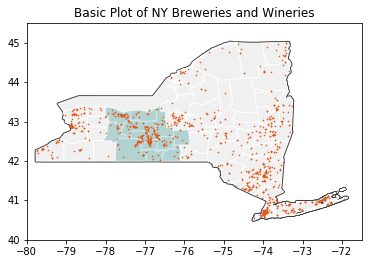

In [9]:
# plot basic outputs with pyplot - we see NY state, counties, and markers (breweries and wineries)
fig, ax = plt.subplots()

# style each layer
ny_state.plot(ax=ax, edgecolor='#404040', linewidth=3, zorder=0);
ny_counties.plot(ax=ax, color='#f0f0f0', edgecolor='white', zorder=1);
finger_lakes_counties.plot(ax=ax, color='teal', alpha=0.25, edgecolor='white', zorder=2)
ny_beer_wine.plot(ax=ax, color='#DE5C1F', markersize=0.4, zorder=3);

# set view 
ax.set(title='Basic Plot of NY Breweries and Wineries', xlim=(-80,-71.5), ylim=(40,45.5))

## Geoprocess Data with GeoPandas<a name="geoprocessing">
    
### Clip Dataset<a name="clip">

We want to look at breweries and wineries exclusively in the Finger Lakes region. While our dataset contains county data that could be queried and filtered, we will instead clip the point data to our Finger Lakes counties shapefile. We use the `intersects` method.

#### Unary Union<a name="union">

Multipolygons tend to cause problems for geoprocessing data. To ensure that our polygons work with GeoPandas methods, we use Shapely's `unary_union` to dissolve into a single polygon.

In [10]:
# unary union to dissolve into single geometry
finger_lakes_counties_poly = finger_lakes_counties.unary_union

# intersect points against polygons
fl_beer_wine = ny_beer_wine[ny_beer_wine.geometry.intersects(finger_lakes_counties_poly)]

### Reproject Data<a name="reproject">

Because we want to create buffers with set distances, we will reproject our data to an equidistant conic projection.

In [11]:
ny_state_prj = ny_state.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
ny_counties_prj = ny_counties.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
fl_beer_wine_prj = fl_beer_wine.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
fl_counties_prj = finger_lakes_counties.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

### Check Data<a name="check-2">

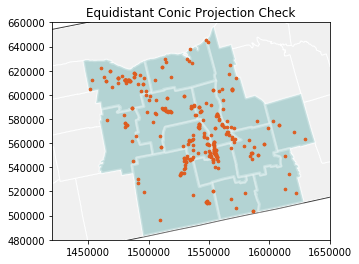

In [12]:
# plot to check proper projection
fig, ax = plt.subplots()

ny_state_prj.plot(ax=ax, edgecolor='#404040', linewidth=3, zorder=0);
ny_counties_prj.plot(ax=ax, color='#f0f0f0', edgecolor='white', zorder=1);
fl_counties_prj.plot(ax=ax, color='teal', alpha=0.25, edgecolor='white', linewidth=3, zorder=2)
fl_beer_wine_prj.plot(ax=ax, color='#DE5C1F', markersize=7, zorder=3);

ax.set(title='Equidistant Conic Projection Check', xlim=(1420000,1650000), ylim=(480000,660000));

### Additional Subsetting and Splitting of Data<a name="additional-subset">

We want to look at breweries versus wineries, so we will split our Finger Lakes data into two separate dataframes. We must first find all unique values for establishment types, format them properly, then subset and split the datasets.

In [13]:
# find all unique values for establishment type
print(fl_beer_wine_prj['type'].unique())

# remove quotations from types for easier subsetting
fl_beer_wine_prj['type'] = fl_beer_wine_prj['type'].str.replace('"', '')

['Brewer' 'Distiller "A-1"' 'Distiller "B"' 'Distiller "B-1"'
 'Distiller "C"' 'Farm Brewer' 'Farm Distiller "D"' 'Farm Winery'
 'Micro Brewer' 'Restaurant Brewer' 'Winery' 'Winery / Farm Winery Retail']


In [14]:
# separate geodataframes for breweries and wineries
fl_beer = fl_beer_wine_prj.query("type == ['Brewer', 'Distiller A-1', 'Distiller B', 'Distiller B-1', 'Distiller C', 'Farm Brewer', 'Farm Distiller D', 'Micro Brewer', 'Restaurant Brewer']")
fl_wine = fl_beer_wine_prj.query("type == ['Winery', 'Winery / Farm Winery Retail', 'Farm Winery']")

# create generic type fields for easier web map subsetting
fl_beer = fl_beer.copy()
fl_beer['type_generic'] = 'other'
fl_wine = fl_wine.copy()
fl_wine['type_generic'] = 'winery'

### Apply Buffer to Wineries Dataset<a name="buffer">
    
We want to check how many breweries are within a half mile of a winery in the Finger Lakes. We must first apply a buffer around our winery points with a distance of 804.672 meters, the equivalent of 0.5 miles. We will then reset the geometry column of the GeoDataFrame to the newly-created buffer column to later perform an intersection with that geometry.

In [15]:
# apply half mile buffer in meters, create copy to avoid chained indexing from sliced dataset
fl_wine = fl_wine.copy()
fl_wine['buffer'] = fl_wine.buffer(804.672)


# reassign main geometry column to buffer
fl_wine = fl_wine.set_geometry('buffer')

### Intersect Half-Mile Buffer Against Dataset<a name="intersect-1">
    
#### Breweries<a name="breweries">

With the buffer applied around each winery, we are able to use an intersection to clip only the breweries that exist within that buffer zone.

In [16]:
# unary union to dissolve multipolygons for geoprocessing
fl_wine_poly = fl_wine.unary_union

# intersection of breweries within a half mile of a winery
fl_beer_int = fl_beer[fl_beer.geometry.intersects(fl_wine_poly)]

#### Check Data<a name="check-3">

Let's take a quick look to make sure that our buffer and intersection was successful.

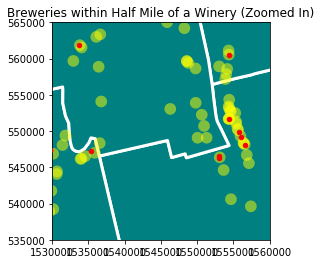

In [17]:
# check buffer and intersction
fig, ax = plt.subplots()

fl_counties_prj.plot(ax=ax, color='teal', edgecolor='white', linewidth=3, zorder=0);
fl_wine.plot(ax=ax, color='yellow',  alpha=0.5, zorder=1);
fl_beer_int.plot(ax=ax, color='red', markersize=20, zorder=3);

# zoom in for closer view of buffer zone
ax.set(title='Breweries within Half Mile of a Winery (Zoomed In)', xlim=(1530000,1560000), ylim=(535000,565000));

#### Wineries<a name="wineries">

Looks good! However, we don't want to see ALL wineries in our original dataset - we only want to look at the wineries that are within a half-mile of a brewery. To filter our winery dataset, we against use an intersection to subset the wineries that intersect breweries. In short, we are removing all yellow circles (plotted above) that do NOT have a red circle on them.

In [18]:
# unary union to dissolve multipolygons for geoprocessing
fl_beer_poly = fl_beer_int.unary_union

# wineries (buffer included) within half mile of brewery
fl_wine_int = fl_wine[fl_wine.geometry.intersects(fl_beer_poly)]

# reset geometry to point (instead of buffer) for plotting
fl_wine_int = fl_wine_int.set_geometry('geometry')

## Final Plot and Analysis<a name="final-plot">

Through GeoPandas geoprocessing methods, we were able to determine which and how many breweries exist within a half mile radius of winery in the Finger Lakes region of upstate New York. We can alter or extend this analysis in a number of ways - we could extend or reduce the buffer area, change the area of interest (all counties in New York, or a different region), or further filter our dataset with more refinement.

Through some basic calcuations (below), we determine that roughly 23% of wineries in the region are within a half mile of a brewery. Slightly more breweries in the region (~31%) are within a half mile of a winery. So if you want to seamlessly walk between establishments, it's easy to do so in approximately a quarter of establishments in the region! Drink responsibly!

While our final map is a fine overview, we'd ideally like to plot this in a dynamic, interactive web map to allow pop-up information, panning, zooming, etc.

In [19]:
wine_pct = round(len(fl_wine_int) / len(fl_wine) * 100, 2)
beer_pct = round(len(fl_beer_int) / len(fl_beer) * 100, 2)

print(f'{wine_pct}% of wineries in the Finger Lakes region of upstate New York are within a half mile of a brewery.')
print(f'{beer_pct}% of breweries in the Finger Lakes region of upstate New York are within a half mile of a winery.')

23.12% of wineries in the Finger Lakes region of upstate New York are within a half mile of a brewery.
30.82% of breweries in the Finger Lakes region of upstate New York are within a half mile of a winery.


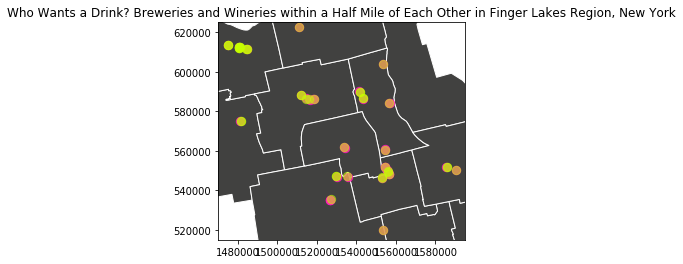

In [20]:
# final plot
fig, ax = plt.subplots()

fl_counties_prj.plot(ax=ax, color='#414140', edgecolor='white', zorder=0);
fl_wine_int.plot(ax=ax, color='#FF1FB8', alpha=0.8, markersize=70, zorder=1);
fl_beer_int.plot(ax=ax, color='#C6FF00', alpha=0.5, markersize=70, zorder=2);

ax.set(
    title='Who Wants a Drink? Breweries and Wineries within a Half Mile of Each Other in Finger Lakes Region, New York',
    xlim=(1470000,1595000),
    ylim=(515000,625000)
);

## Export Results <a name="export">
    
### Export Dataset to CSV and JSON<a name="export-dataset">

In [21]:
# remove buffer column from wine dataframe
wine = fl_wine_int.drop('buffer', axis=1)

# merge beer and wine geodataframes
beer_wine_final = pd.concat([fl_beer_int, wine])

# convert back to wgs84
beer_wine_final.to_crs(epsg=4326, inplace=True)

# export to csv
beer_wine_final.to_csv('./data/beer_wine_fingerlakes.csv')

# export dataset and county shapefiles to geojson for web mapping
beer_wine_final.to_file('./data/beer_wine_fingerlakes.json', driver='GeoJSON')
fl_counties_prj.to_file('./data/fingerlakes_counties.json', driver='GeoJSON')

# display to check
beer_wine_final

,type,county,official_business_name,name,address,city,state,zip,lat,lng,geometry,type_generic
1,Brewer,Monroe,Narragansett Brewing Company,Narragansett Brewing Company,445 St Paul St,Rochester,NY,14605,43.164590,-77.614460,POINT (-77.61445999999999 43.16459),other
7,Brewer,Monroe,High Falls Operating Co Llc/Licensing Co Llc,High Falls Brewing Co/North American Breweries,445 St Paul St,Rochester,NY,14605,43.164931,-77.614371,POINT (-77.61437097000001 43.16493105000001),other
8,Brewer,Monroe,Mark Anthony Brewing Inc,Mikes Hard Lemonade Co,445 St Paul St,Rochester,NY,14605,43.164931,-77.614371,POINT (-77.61437097000001 43.16493105000001),other
9,Brewer,Monroe,Lidestri Beverages Llc,Lidestri Spirits,1050 Lee Rd,Rochester,NY,14606,43.187710,-77.679800,POINT (-77.6798 43.18771000000001),other
10,Brewer,Ontario,Constellation Brands Inc,Constellation Brands,116 Buffalo St,Canandaigua,NY,14424,42.896416,-77.293768,POINT (-77.29376827999999 42.89641639999999),other
...,...,...,...,...,...,...,...,...,...,...,...,...
1212,Winery,Monroe,High Falls Operating Co Llc,North American Breweries,445 St Paul St,Rochester,NY,14605,43.164931,-77.614371,POINT (-77.61437097000001 43.16493105000001),winery
1223,Winery,Schuyler,J R Dill Winery Llc,J R Dill Winery,4922 State Route 414,Burdett,NY,14818,42.471450,-76.867544,POINT (-76.86754395 42.4714497),winery
1227,Winery,Seneca,Ventosa Vineyards Llc,Ventosa Vineyards,3440 Route 96A,Geneva,NY,14456,42.859068,-76.936316,POINT (-76.93631553 42.85906812999999),winery
1229,Winery,Tompkins,Ports Of New York Llc,Ports Of New York,815 Taber St,Ithaca,NY,14850,42.438458,-76.513509,POINT (-76.51350850000001 42.43845772999999),winery


### Export Counties to JSON<a name="export-counties">

Because we are going to import our polygons into a web map, we must convert them back to the WGS84 Web Mercator coordinate reference system before exporting them to JSON.

In [24]:
# convert back to wgs84 before saving
fl_counties_prj.to_crs(epsg=4326, inplace=True)
fl_counties_prj.to_file('./data/fingerlakes_counties.json', driver='GeoJSON')